In [45]:
import uproot
import awkward as ak
import numpy as np
import math
import hist
import matplotlib.pyplot as plt
import os
import subprocess
import vector
import gc
from itertools import product
import sys
import ROOT

from Plot import Plot

vector.register_awkward() 
DATATYPE="mc"
BASEDIR="/pbs/throng/training/nantes-m2-rps-exp/data"
SAMPLE_RUN = 291694
MUON_MASS = 0.105
D_ABS = 500

events_tree = f"{BASEDIR}/run{SAMPLE_RUN}.{DATATYPE}.root:eventsTree"

if DATATYPE=="mc":
    gen_tree = f"{BASEDIR}/run{SAMPLE_RUN}.{DATATYPE}.root:genTree"

In [63]:
def getTracks(events):
    return ak.zip({ "px":events["Muon_Px"],
                    "py":events["Muon_Py"],
                    "pz":events["Muon_Pz"],
                    "E":events["Muon_E"],
                    "DCAx":events["Muon_xDCA"],
                    "DCAy":events["Muon_yDCA"],
                    "DCAz":events["Muon_zDCA"],
                    "charge":events["Muon_Charge"],
                    "thetaAbs":events["Muon_thetaAbs"],
                    "matched":events["Muon_matchedTrgThreshold"],
                    "PDGcode":events["PDGcode"]},
                    with_name='Momentum4D')

def getgenTracks(genevents):
    return ak.zip({ "px":genevents["Muon_GenPx"],
                    "py":genevents["Muon_GenPy"],
                    "pz":genevents["Muon_GenPz"],
                    "E":genevents["Muon_GenE"]},
                    with_name='Momentum4D')

In [64]:
def applySelection(data, criteria, plot=False, **kwargs):
    # Select data using function "criteria"
    selected = data[criteria(data)]
    if plot:
        hist_before = hist.Hist(hist.axis.Regular(bins=100,start=0,stop=20,name='$|p|$'))
        hist_after = hist.Hist(hist.axis.Regular(bins=100,start=0,stop=20,name='$|p|$'))
        try:
            hist_before.fill(ak.flatten(data.pt))
            hist_after.fill(ak.flatten(selected.pt))
        except AttributeError:
            hist_before.fill(ak.flatten(getTracks(data).pt))
            hist_after.fill(ak.flatten(getTracks(selected).pt))
        Plot(hist_before, hist_after, **kwargs)
    return selected

In [65]:
def get_pDCA_infos(goodTracks):
    DCA=np.sqrt(goodTracks.DCAx**2 + goodTracks.DCAy**2 + goodTracks.DCAz**2)
    p0=ak.where(goodTracks.thetaAbs < 3 , goodTracks.p - 3.0, goodTracks.p - 2.4)
    pDCA=p0*DCA
    
    N=3 #choice of resolution should be a number between 1 and 10
    sigmaAbs=ak.where(goodTracks.thetaAbs < 3, 80.0, 54.0) #factor used due to the crossed materials 
    pRes= 0.0004 * goodTracks.p
    sigmap= sigmaAbs/ (1 - ((N*pRes)/(1 + N*pRes)))

    thetaRes= 0.0005 * goodTracks.p
    sigmatheta= 535 * thetaRes

    #computing total resolution for pDCA
    sigmapDCA=np.sqrt(sigmap**2 + sigmatheta**2)

    goodTracks["pDCA"] = pDCA

    return pDCA, N, sigmapDCA

In [141]:
def analyzeGenTree():
    assert gen_tree
    for batch in uproot.iterate(gen_tree,
                                ["zVtxMC", "nMuonsGen", "Muon_GenPx","Muon_GenPy","Muon_GenPz","Muon_GenE","Muon_GenLabel","Muon_GenMotherPDGCode"],                                
                                 report=True):
        events = batch[0]
        print(dir(events))
        hist_E = hist.Hist(hist.axis.Regular(bins=100,start=0,stop=100,name='$|pt|$'))
        hist_E.fill(ak.flatten(events.Muon_GenE))
        hist_z = hist.Hist(hist.axis.Regular(bins=100,start=-20,stop=20,name='z'))
        hist_z.fill(events.zVtxMC)

        codes = events.Muon_GenMotherPDGCode
        print(sum(ak.flatten(codes) == 443)/2, "J/psi générés")
        print(sum(ak.flatten(codes) == 100443)/2, "Psi(2S) générés")

        return codes
        
        #Plot(hist_E)
        #Plot(hist_z)

In [142]:
def analyzeEventsTree():
    for batch in uproot.iterate(events_tree,
                                ["zVtx", "nMuons", "isCINT","isCMUL","isCMSL","Muon_Px","Muon_Py","Muon_Pz","Muon_E","Muon_xDCA","Muon_yDCA","Muon_zDCA","Muon_Charge","Muon_thetaAbs","Muon_matchedTrgThreshold"],                                
                                 report=True):
        events=batch[0]

        PDGcodes = analyzeGenTree()
        events["PDGcode"] = PDGcodes[..., 0]

        def select_charge(events):
            charge = []
            for charges in events["Muon_Charge"]:
                if (-1 in charges) and (1 in charges):
                    charge += [True]
                else:
                    charge += [False]
            return charge

        def select_z(events):
            z = events["zVtx"]
            return (z < 10) & (z > -10)

        select_nb = lambda events: events["nMuons"] >= 2

        goodEvents = applySelection(events, select_nb, plot=False, title="Nb selection")
        goodEvents = applySelection(goodEvents, select_z, plot=False, title="z selection")
        goodEvents = applySelection(goodEvents, select_charge, plot=False, title="charge selection")

        tracks = getTracks(goodEvents)
        print(tracks[0].PDGcode)

        select_pt = lambda tracks: tracks.pt > 1
        select_match = lambda tracks: tracks.matched >= 1
        select_eta = lambda tracks: (tracks.eta < -2.5) & (tracks.eta > -4)
        select_Rabs = lambda tracks: (D_ABS * np.tan(tracks.thetaAbs*np.pi/180) < 90) & (D_ABS * np.tan(tracks.thetaAbs*np.pi/180) > 17.5)
    
        
        goodTracks = applySelection(tracks, select_pt, plot=True, title="pt selection")
        goodTracks = applySelection(goodTracks, select_match, plot=False, title="match selection")
        goodTracks = applySelection(goodTracks, select_eta, plot=False, title="eta selection")
        goodTracks = applySelection(goodTracks, select_Rabs, plot=False, title="R_abs selection")

        pDCA, N, sigmapDCA = get_pDCA_infos(goodTracks)
        # for N in range(1, 15):
            # select_pDCA = lambda tracks: pDCA < N*sigmapDCA
            # goodTracks_ = applySelection(goodTracks, select_pDCA, plot=True, title=f"pDCA selection, N = {N}")
        select_pDCA = lambda tracks: pDCA < N*sigmapDCA
        goodTracks_ = applySelection(goodTracks, select_pDCA, plot=True, title=f"pDCA selection, N = {N}")
        invariant_mass = []
        invariant_mass_psi2s = []
        # Pair tracks and calculate invarant mass
        for eventTracks in goodTracks:
            if len(eventTracks) < 2: continue
            positive = eventTracks[eventTracks.charge == 1] #Tracks with positive charge
            negative = eventTracks[eventTracks.charge == -1] #Tracks with negative charge
            matched_pair = [] # List to store tracks already paired
            for p, n in product(positive, negative):
                if p in matched_pair or n in matched_pair: continue
                if abs(p.pDCA - n.pDCA) < 100: # Trouver une meilleure coupure
                    if eventTracks.PDGcode[0] == 443:
                        invariant_mass.append(np.sqrt(2*MUON_MASS**2 + 2*p.dot(n)))
                    else:
                        invariant_mass_psi2s.append(np.sqrt(2*MUON_MASS**2 + 2*p.dot(n)))
                    matched_pair.append(p)
                    matched_pair.append(n)
                    
                            
        mass_hist = hist.Hist(hist.axis.Regular(bins=100,start=0,stop=5,name='$|pt|$'))
        mass_hist.fill(invariant_mass)
        Plot(mass_hist, title="Invariant mass", save=True)
        mass_hist2 = hist.Hist(hist.axis.Regular(bins=100,start=0,stop=5,name='$|pt|$'))
        mass_hist2.fill(invariant_mass_psi2s)
        Plot(mass_hist2, title="Invariant mass Psi2S", save=True)
        print(mass_hist.sum(), "J/psi")
        print(mass_hist2.sum(), "Psi(2S)")

        return invariant_mass, invariant_mass_psi2s
        

        # Plot(vhMagRaw, vhMagRaw2, labelx=r"zVtx", save=True, savename="zVtx_cut")


['Mask', 'Muon_GenE', 'Muon_GenLabel', 'Muon_GenMotherPDGCode', 'Muon_GenPx', 'Muon_GenPy', 'Muon_GenPz', '__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__get__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__self__', '__self_class__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__thisclass__', '_attrs', '_behavior', '_cpp_type', '_layout', '_numbaview', 'attrs', 'behavior', 'cpp_type', 'fields', 'is_tuple', 'layout', 'mask', 'nMuonsGen', 'nbytes', 'ndim', 'numba_type', 'show', 'to_list', 'to_numpy', 'tolist', 'type', 'typestr', 'zVtxMC']
26669.0 J/psi générés
13331.0 Psi(2S) générés
[100443, 100443]


/pbs/home/s/subatech03/qqbar2mumu-2025/notebooks/MC/Plot.py:49: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


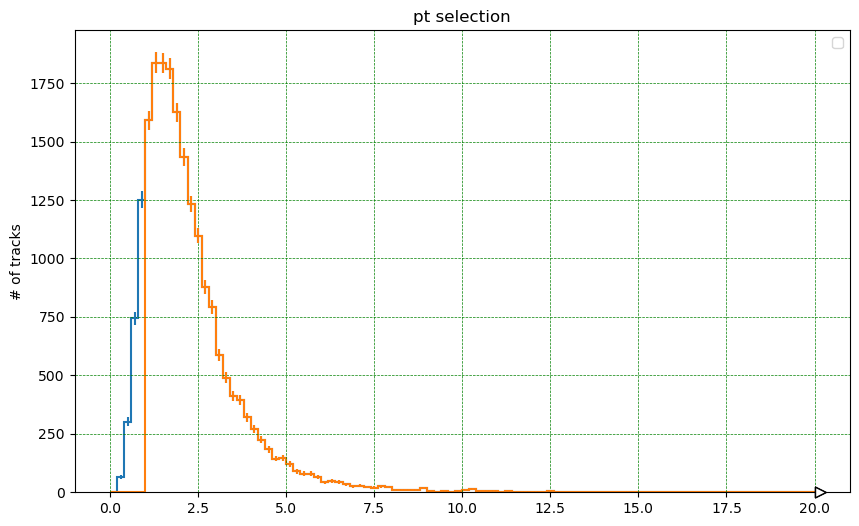

/pbs/home/s/subatech03/qqbar2mumu-2025/notebooks/MC/Plot.py:49: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


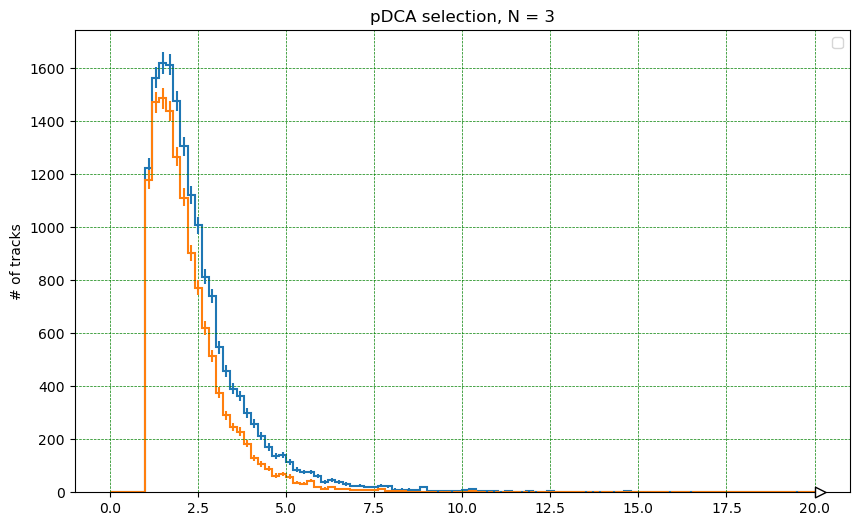

/pbs/home/s/subatech03/qqbar2mumu-2025/notebooks/MC/Plot.py:49: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


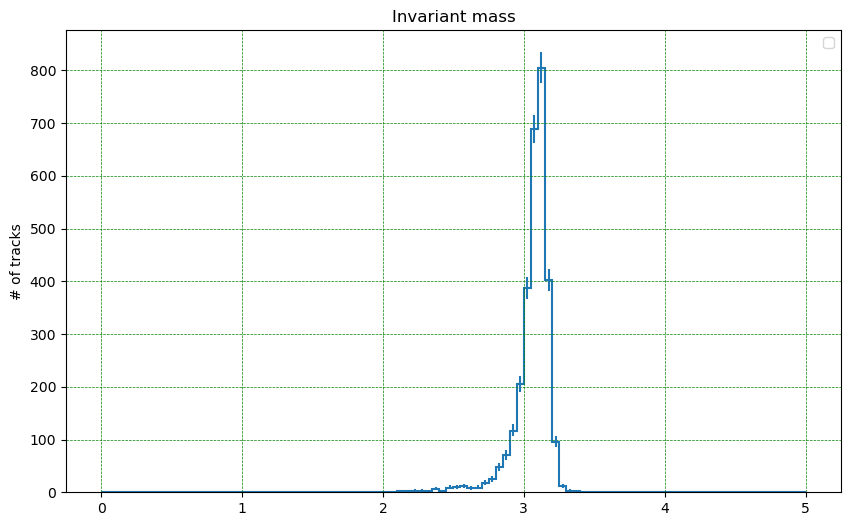

/pbs/home/s/subatech03/qqbar2mumu-2025/notebooks/MC/Plot.py:49: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


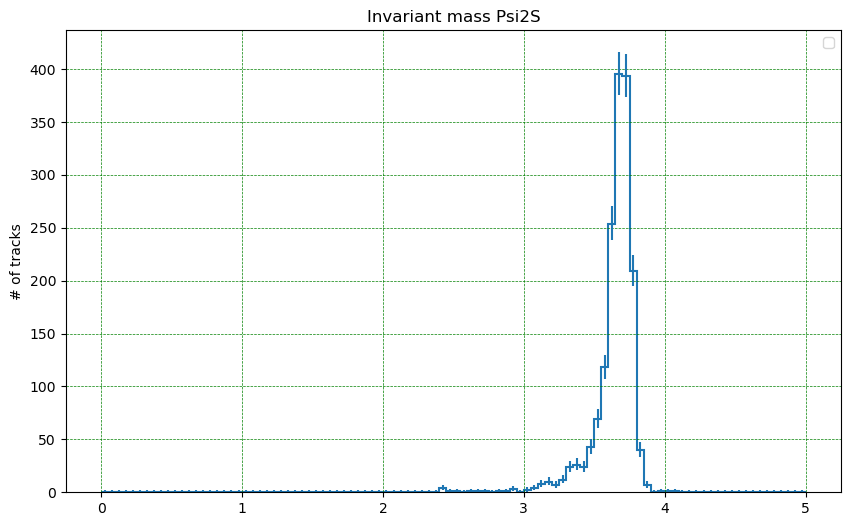

2947.0 J/psi
1662.0 Psi(2S)


In [143]:
inv_mass, inv_mass2 = analyzeEventsTree()

In [137]:
pt = ROOT.RooRealVar("pt", "pt", 1.5, 5)
mean1 = ROOT.RooRealVar("mean", "mean of gaussian", 3.1, 1.5, 5)
sigma1 = ROOT.RooRealVar("sigma", "width of gaussian", 0.05, 0, 1)
alpha1 = ROOT.RooRealVar("alpha", "alpha", 1, 0, 5)
n1 = ROOT.RooRealVar("n", "n", 2, 1, 10)
gauss = ROOT.RooCBShape("gauss", "gaussian PDF", pt, mean1, sigma1, alpha1, n1)

pt.setBins(100)  # Set bins for plotting

# Create a RooDataSet and fill it with the data
data_set = ROOT.RooDataSet.from_numpy({"pt": np.array(inv_mass)}, [pt])
# data_set = ROOT.RooDataSet("data_set", "data_set", ROOT.RooArgSet(pt1))
# for value in invariant_mass:
    # pt1.setVal(value)
    # data_set.add(ROOT.RooArgSet(pt1))

xframe = pt.frame(Title="Gaussian pdf with data")  # RooPlot
data_set.plotOn(xframe)
gauss.plotOn(xframe)

gauss.fitTo(data_set)

mean1.Print()
sigma1.Print()

c = ROOT.TCanvas("rf101_basics", "rf101_basics", 800, 400)
xframe.Draw()


c.SaveAs("rf101_basics.png")

[#0] WARNING:DataHandling -- RooDataSet.from_numpy() Ignored 1 out-of-range events
[#1] INFO:Fitting -- RooAbsPdf::fitTo(gauss_over_gauss_Int[pt]) fixing normalization set for coefficient determination to observables in data
[#1] INFO:Fitting -- RooAddition::defaultErrorLevel(nll_gauss_over_gauss_Int[pt]_) Summation contains a RooNLLVar, using its error level
[#1] INFO:Minimization -- RooAbsMinimizerFcn::setOptimizeConst: activating const optimization
Minuit2Minimizer: Minimize with max-calls 2000 convergence for edm < 1 strategy 1
Minuit2Minimizer : Valid minimum - status = 0
FVAL  = -2770.61265156360059
Edm   = 0.000252216220131672804
Nfcn  = 126
alpha	  = 0.882423	 +/-  0.0553464	(limited)
mean	  = 3.10465	 +/-  0.00200843	(limited)
n	  = 4.34613	 +/-  0.511751	(limited)
sigma	  = 0.0587376	 +/-  0.00148846	(limited)
[#1] INFO:Minimization -- RooAbsMinimizerFcn::setOptimizeConst: deactivating const optimization
RooRealVar::mean = 3.10465 +/- 0.00201228  L(1.5 - 5) 
RooRealVar::sigma

Info in <Minuit2>: MnSeedGenerator Computing seed using NumericalGradient calculator
Info in <Minuit2>: MnSeedGenerator Initial state: FCN =      -2642.061263 Edm =        139.309304 NCalls =     17
Info in <Minuit2>: MnSeedGenerator Initial state  
  Minimum value : -2642.061263
  Edm           : 139.309304
  Internal parameters:	[    -0.6435011088   -0.08581959051    -0.8911225079     -1.119769515]	
  Internal gradient  :	[     -612.7650521     -12956.58001     -428.8586517     -2422.200577]	
  Internal covariance matrix:
[[  0.00025502328              0              0              0]
 [              0   9.065384e-07              0              0]
 [              0              0  0.00098591967              0]
 [              0              0              0  2.1811185e-05]]]
Info in <Minuit2>: VariableMetricBuilder Start iterating until Edm is < 0.001 with call limit = 2000
Info in <Minuit2>: VariableMetricBuilder    0 - FCN =      -2642.061263 Edm =        139.309304 NCalls =     17